# ARE YOU ATTRACTIVE OR NOT? (LET SEE WHAT NEURAL NETWORKS HAVE TO SAY)

## INTRODUCTION 

The objective of this project is trying to predict if a person is attractive or not, based on almost 200k images of celebrities. 

This dataset has information of attributes like gender, hair color, the eyebrows, big lips, big nose, makeup, all of these binary attributes. 

For this project I have two approaches, both of them using neural networks, the firs approach is using attractive as target and using the other attributes as predictors. For the second approach I'll be using the images on the dataset to predict the attribute 'attractive'.

This data was collected by the Chinese University of Hong Kong.

The original images have different backgrounds, sizes and angles for each person. 




### Imports

For this project I'll be  using Tensorflow version 1.13.1, the available one at the kaggle kernels**.

In [2]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
print(os.listdir("../input"))


['list_attr_celeba.csv', 'list_eval_partition.csv', 'list_landmarks_align_celeba.csv', 'img_align_celeba', 'list_bbox_celeba.csv']


In [3]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from time import time
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64
from keras.utils import np_utils

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation 

from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML


from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard 

plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


In [4]:
import tensorflow as tf
print(tf.__version__)

1.13.1


## Exploring the dataset

As the target variable is the attractive attribute it is important to see it's relationship with other attibutes. 

The most correlated attributes with the target variable are the lipstick with a 48% correlation, young with a 38% correlation, 47% correlation with heavy makeup and a weak correlation of 25% with arched eyebrows.


In [5]:
main_folder = '../input/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000225.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20


In [6]:
# import the data set that include the attribute for each picture
data = pd.read_csv(main_folder + 'list_attr_celeba.csv')
data.set_index('image_id', inplace=True)
data.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
data.shape

(202599, 40)

Attractive    1
Male          0
Young         1
Name: 000225.jpg, dtype: int64

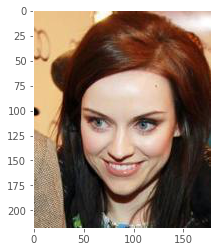

In [7]:
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
data.loc[EXAMPLE_PIC.split('/')[-1]][['Attractive','Male','Young']] #some attributes

The attractive attribute class is almost balanced, therefore I'm not going to use any class balance algorithm. Other important attributes are almost balanced as well.

In the plots below it is able to see the class balance for some important attributes.

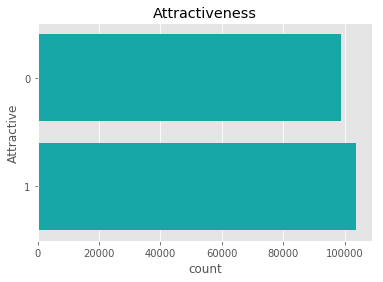

In [8]:
plt.title('Attractiveness')
sns.countplot(y='Attractive', data=data, color="c")
plt.show()

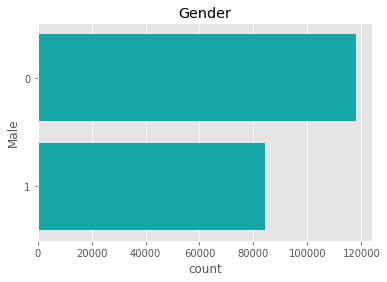

In [9]:
plt.title('Gender')
sns.countplot(y='Male', data=data, color="c")
plt.show()

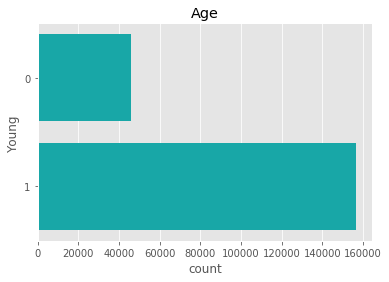

In [10]:
plt.title('Age')
sns.countplot(y='Young', data=data, color="c")
plt.show()

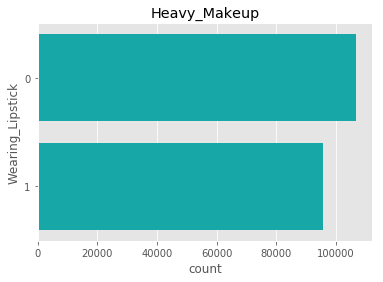

In [12]:
plt.title('Heavy_Makeup')
sns.countplot(y='Wearing_Lipstick', data=data, color="c")
plt.show()

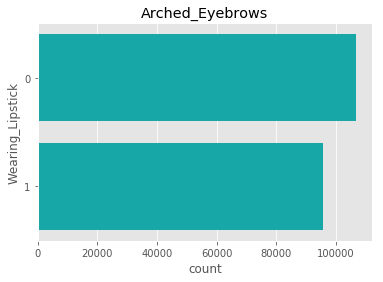

In [11]:
plt.title('Arched_Eyebrows')
sns.countplot(y='Wearing_Lipstick', data=data, color="c")
plt.show()

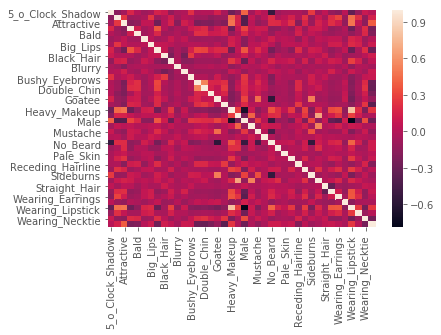

In [13]:
corr = data.corr()
sns.heatmap(corr)

In [14]:
corr

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
5_o_Clock_Shadow,1.000000,-0.158587,-0.062415,0.168488,0.005584,-0.089243,-0.043699,0.152010,1.006038e-01,-0.132686,-0.033370,-0.012294,0.217964,-0.010260,0.002811,0.007306,0.143860,-0.043832,-0.280585,-0.160536,0.417670,-0.066493,0.092123,0.011282,-0.526946,-0.085337,-0.040279,-0.024305,-2.227337e-02,-0.090107,0.259370,-0.067777,0.052260,-0.124250,-0.161911,0.033997,-0.333921,-0.116239,0.097899,0.014869
Arched_Eyebrows,-0.158587,1.000000,0.250599,-0.091947,-0.069524,-0.027775,0.243400,-0.084025,-9.959764e-04,0.127009,-0.075948,0.017850,-0.018046,-0.089423,-0.078133,-0.148923,-0.112795,-0.099181,0.439645,0.156242,-0.408016,0.066923,-0.086341,0.024175,0.202724,-0.013440,0.047715,0.153057,-1.676842e-02,0.224422,-0.116001,0.093834,-0.054486,0.200835,0.294779,-0.099980,0.460409,0.220184,-0.132821,0.146798
Attractive,-0.062415,0.250599,1.000000,-0.178464,-0.145826,0.059712,0.062552,-0.277064,4.139890e-03,0.154774,-0.180969,0.132069,0.042283,-0.236877,-0.208981,-0.222701,-0.146613,-0.201796,0.477084,0.149095,-0.394451,0.021465,-0.140182,-0.073882,0.197655,0.193939,0.086051,0.228292,-1.786768e-01,0.163867,-0.100229,0.147845,0.041550,0.214992,0.124349,-0.138636,0.480104,0.068738,-0.156420,0.387735
Bags_Under_Eyes,0.168488,-0.091947,-0.178464,1.000000,0.116215,-0.057568,-0.005982,0.361604,2.667485e-03,-0.106879,-0.032765,-0.046492,0.107066,0.157286,0.196207,-0.042397,0.095434,0.171652,-0.293319,0.072873,0.301077,0.058761,0.109952,0.106856,-0.146539,-0.135912,-0.032892,-0.113986,1.170317e-01,-0.093963,0.100411,0.112759,0.024208,-0.127128,-0.096969,-0.005726,-0.284052,-0.052964,0.196980,-0.230759
Bald,0.005584,-0.069524,-0.145826,0.116215,1.000000,-0.064044,-0.003577,0.180148,-8.036419e-02,-0.063056,-0.009315,-0.076741,-0.020176,0.223647,0.212874,0.109383,0.115220,0.151304,-0.120235,-0.002277,0.178101,-0.000477,0.079672,0.012362,-0.115658,0.010788,-0.023222,-0.055636,1.402357e-01,-0.037363,0.058599,0.009402,-0.071920,-0.103482,-0.061211,-0.030625,-0.142852,-0.050445,0.176501,-0.196253
Bangs,-0.089243,-0.027775,0.059712,-0.057568,-0.064044,1.000000,0.034876,-0.069395,-3.355778e-02,0.098854,-0.009083,0.069450,-0.072552,-0.084137,-0.069531,-0.059005,-0.085602,-0.061601,0.120416,0.052970,-0.163264,0.009486,-0.067445,0.013018,0.132429,0.001626,0.042170,0.010973,-1.242493e-01,0.060977,-0.073341,0.052469,0.020034,0.068166,0.058203,-0.079939,0.163378,0.114454,-0.092919,0.017695
Big_Lips,-0.043699,0.243400,0.062552,-0.005982,-0.003577,0.034876,1.000000,0.076814,6.719131e-02,0.023674,-0.037086,-0.015361,0.020804,0.007811,-0.009559,-0.050522,0.019088,-0.088191,0.146551,0.045165,-0.167472,0.048973,0.031484,0.113577,0.022777,-0.112263,0.039337,0.052646,2.096284e-02,0.076767,-0.039739,0.012885,-0.037144,0.120190,0.126523,-0.013286,0.195212,0.149892,-0.067770,0.107722
Big_Nose,0.152010,-0.084025,-0.277064,0.361604,0.180148,-0.069395,0.076814,1.000000,8.109064e-02,-0.158323,-0.037710,-0.133210,0.141162,0.314317,0.298426,0.139555,0.194172,0.195750,-0.278479,0.058757,0.369275,0.059408,0.207882,0.070165,-0.253800,-0.105909,-0.051177,-0.158633,2.024274e-01,-0.055323,0.131667,0.100888,-0.028837,-0.131843,-0.058029,0.065552,-0.303651,-0.035930,0.205014,-0.284382
Black_Hair,0.100604,-0.000996,0.004140,0.002667,-0.080364,-0.033558,0.067191,0.081091,1.000000e+00,-0.233626,-0.037961,-0.252398,0.257974,0.009766,-0.027753,-0.016151,0.058992,-0.116771,-0.049240,0.008496,0.116279,-0.023168,0.063848,-0.011000,-0.098675,0.031887,-0.038675,-0.046623,-5.486097e-07,-0.039809,0.043231,-0.002533,0.112496,-0.085227,0.0

### Train test split

Train and test split for the moodels using attributes as **preditors.

In [15]:
y = data["Attractive"]
X = data.drop(['Attractive'], axis=1)

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [19]:
X_train.shape, X_test.shape

((151949, 39), (50650, 39))

In [21]:
df = []
labels = []
for img in images_folder:
    try:
        img_read = plt.imread( images_folder + "/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        df.append(img_array)
        labels.append(1)
    except:
        None

In [ ]:
X_train.shape, X_test.shape

# METHODS 

For this project the neural networks models were Sequential models. This models are linear stacks of layers. 

With model.add it is possible to add as much layers as you want. Usually, multilayer models have an input layer, hidden layers and an output layer.

For the first layer of a sequential model it is needed to specify the information about the input, like the input shape and the input dimension. 

Before getting to testing the model it is needed to compile the model. In the compilation process you can decide which optimizer and metric you are going to use to evaluate your model.

After compilation, with the fit function it is possible to train the model.

In this model a multilayer perceptron for binary classification model was used. 

Neural networks have some basic components: input nodes, connections, transfer or activation function, output node and bias.

Each connection of each input node has weights associated.Then all the values of the input nodes are used as input as a weighted sum wich will be the input for the transfer function. Transfer funcitons are activated only when an specific threshold is exceeded. As a result there's an output node (it is associated with the function).

### Convolutional Neural Networks

A Convolutional Neural Network is a deep learning algorithm that takes images as input.

For these models images are used as different levels of pixels matrix, each "level" specifies the color (trhough RGB, 3 layers) and each image has height and width dimensions. 

These algorithms can easily turn computationally expensive.

## Only using the csv

### First Neural network

In [ ]:
model = tf.keras.Sequential()
model.add(Dense(64, input_dim=39, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          epochs=20,
          batch_size=128)
score = model.evaluate(X_test, Y_test, batch_size=128)

In [ ]:
model.history

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

In [ ]:
predictions = model.predict(X_test)


### Second Neural network

In [ ]:
model = tf.keras.Sequential()
model.add(Dense(64, input_dim=39, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          epochs=20,
          batch_size=128)
score = model.evaluate(X_test, Y_test, batch_size=128)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

## Using the images

In [ ]:
first_model = tf.keras.Sequential()

In [ ]:
first_model.add(Flatten(input_shape=(39,1)))


In [ ]:
first_model.add(Dense(64, activation='sigmoid'))

In [ ]:
first_model.add(Dense(10, ))

In [ ]:
first_model.compile(optimizer = 'sgd',
                    loss = 'sparse_categorical_crossentropy',
                    metrics = ['accuracy'])

In [ ]:
model_history = first_model.fit(x = X_train,
                                y = y_train,
                                batch_size = 128,
                                epochs = 5,
                                validation_split = 0.2,
                                shuffle=True)

In [ ]:
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

In [ ]:
#df_partition.set_index('image_id', inplace=True)
#df_par_attr = df_partition.join(data['Attractive'], how='inner')
df_par_attr.head()

In [ ]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (50, 50)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

In [ ]:
##TESTING FUNCTION

def data(data)
    x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

In [ ]:
x_train, y_train = generate_df(1, "Attractive", 10000)
x_test, y_test = generate_df(0, "Attractive", 2000)

In [ ]:
x_train.shape, x_test.shape

In [ ]:
y_train.shape, y_test.shape

In [ ]:
first_model = tf.keras.Sequential()
first_model.add(Flatten(input_shape=(50, 50)))
first_model.add(Dense(64, activation='sigmoid'))
first_model.add(Dense(10, ))
first_model.compile(optimizer = 'sgd',
                    loss = 'sparse_categorical_crossentropy',
                    metrics = ['accuracy'])

In [ ]:
model_history = first_model.fit(x = x_train,
                                y = y_train,
                                batch_size = 128,
                                epochs = 5,
                                validation_split = 0.2,
                                shuffle=True)

In [ ]:
model = tf.keras.Sequential()
model.add(Dense(64, input_dim=39, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=20,
          batch_size=128)
score = model.evaluate(X_test, y_test, batch_size=128)

## CONCLUSIONS

Convolutional Neural Networks can be helpful when trying to work with images. This models can easily turn computationally expensive.


## APPENDIX
* https://keras.io/getting-started/sequential-model-guide/
* https://www.tensorflow.org/tutorials/keras/basic_classification
* https://www.datacamp.com/community/tutorials/deep-learning-python